<a href="https://www.kaggle.com/code/zahrasyifaul/gan-ml?scriptVersionId=256398631" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# import library

In [7]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
from torchvision import transforms
import os


Setup & Import Library

Sel ini berisi semua library yang kita butuhkan.
- torch & torchvision: untuk membangun model, memuat data, dan transformasi.
- matplotlib.pyplot: untuk visualisasi loss dan gambar.
- os: untuk membuat direktori (folder).


# hyperparameter

In [8]:

epochs = 100
lr = 0.0002
batch_size = 128
latent_dim = 100 # Dimensi input noise untuk generator
image_size = 28 * 28 # 784
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Membuat folder untuk menyimpan gambar hasil generate
if not os.path.exists('generated_images'):
    os.makedirs('generated_images')

Using device: cpu


Konfigurasi & Hyperparameter

Menyimpan semua parameter di satu tempat agar mudah diubah.
- epochs: Berapa kali kita melatih model pada seluruh dataset.
- lr: Learning rate, seberapa cepat model belajar.
- batch_size: Jumlah data yang diproses dalam satu iterasi.
- latent_dim: Ukuran vektor noise acak sebagai input untuk Generator.
- image_size: Ukuran gambar MNIST (28x28 = 784 piksel).
- device: Menggunakan GPU ('cuda') jika tersedia, jika tidak pakai CPU.


# load dataset fashion mnist

In [9]:
# 1. Definisikan transform-nya. Pastikan ada transforms.ToTensor()
transform = transforms.Compose([
    transforms.ToTensor(), # WAJIB: Mengubah gambar PIL menjadi Tensor
    transforms.Normalize(mean=[0.5], std=[0.5]) # Normalisasi nilai piksel ke [-1, 1]
])

# 2. Terapkan transform ke dataset saat inisialisasi
train_dataset = datasets.FashionMNIST(
    root='./data/',
    train=True,
    transform=transform,  # <<< PASTIKAN BARIS INI ADA
    download=True
)

# 3. Buat DataLoader seperti biasa
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=128, # Sesuaikan dengan batch_size-mu
    shuffle=True
)

print("Dataset dan DataLoader siap digunakan!")

Dataset dan DataLoader siap digunakan!


# load GAN model

In [10]:

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, image_size),
            nn.Tanh() # Output antara -1 dan 1
        )

    def forward(self, x):
        return self.model(x)

# Diskriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(image_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid() # Output probabilitas
        )

    def forward(self, x):
        return self.model(x)


 Mendefinisikan Arsitektur Model


 --- Generator ---
 Menerima input vektor noise (latent_dim) dan menghasilkan gambar palsu
 seukuran gambar asli (image_size).
 - Linear layer: Lapisan fully-connected.
 - LeakyReLU: Fungsi aktivasi yang membantu mengatasi "dying ReLU problem".
 - Tanh: Fungsi aktivasi terakhir untuk menghasilkan output antara -1 dan 1,
 sesuai dengan normalisasi data kita.



 --- Discriminator ---
Menerima input gambar (image_size) dan menghasilkan probabilitas 0 (palsu) atau 1 (asli).
 - Sigmoid: Fungsi aktivasi terakhir untuk menghasilkan output probabilitas (0-1).




# inisialisasi loss n optimizer

In [11]:
# =============================================================================
# ## 6. Inisialisasi Model, Loss, dan Optimizer (Perbaikan)
# =============================================================================

generator = Generator().to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()

# 🔧 Perbaikan utama:
# - Discriminator pakai LR lebih kecil supaya tidak terlalu dominan
# - Generator LR sedikit lebih besar agar bisa mengejar
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))  # G belajar lebih agresif
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.00005, betas=(0.5, 0.999))  # D lebih lambat

# Vektor noise tetap untuk evaluasi progress
fixed_noise = torch.randn(64, latent_dim).to(device)

# List untuk simpan history loss
g_losses = []
d_losses = []

# training loop

In [12]:
# =============================================================================
# ## 7. Training Loop (Perbaikan)
# =============================================================================
print("Memulai proses training dengan perbaikan...")
for epoch in range(epochs):
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.view(-1, image_size).to(device)
        batch_size_current = real_images.shape[0]
        
        # 🔧 Perbaikan 1: Label smoothing untuk real (bukan 1.0 tapi 0.9)
        real_labels = torch.full((batch_size_current, 1), 0.9, device=device)  
        fake_labels = torch.zeros(batch_size_current, 1).to(device)

        # ---------------------
        #  Latih Discriminator
        # ---------------------
        optimizer_d.zero_grad()
        
        # Loss gambar asli
        outputs_real = discriminator(real_images)
        d_loss_real = criterion(outputs_real, real_labels)

        # Loss gambar palsu
        noise = torch.randn(batch_size_current, latent_dim).to(device)
        fake_images = generator(noise)
        outputs_fake = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs_fake, fake_labels)

        # Total loss D
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        optimizer_d.step()

        # -----------------
        #  Latih Generator
        # -----------------
        optimizer_g.zero_grad()

        # 🔧 Perbaikan 2: Label smoothing juga bisa dipakai untuk target G → gunakan 1.0 tapi kadang digeser sedikit
        # Misalnya pakai target random antara 0.8 - 1.0 agar training lebih stabil
        smooth_real = torch.empty(batch_size_current, 1, device=device).uniform_(0.8, 1.0)
        outputs_fake_for_g = discriminator(fake_images)
        g_loss = criterion(outputs_fake_for_g, smooth_real)

        g_loss.backward()
        optimizer_g.step()

    # Simpan history loss
    g_losses.append(g_loss.item())
    d_losses.append(d_loss.item())
        
    if (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")
        
        with torch.no_grad():
            generated_images = generator(fixed_noise).view(-1, 1, 28, 28)
            save_image(generated_images, f"generated_images/epoch_{epoch+1}.png", normalize=True)

torch.save(generator.state_dict(), 'generator_fixed.pth')
torch.save(discriminator.state_dict(), 'discriminator_fixed.pth')
print("Training selesai (versi perbaikan) dan model disimpan.")

Memulai proses training dengan perbaikan...
Epoch [5/100], D Loss: 1.3319, G Loss: 0.7805
Epoch [10/100], D Loss: 1.3035, G Loss: 0.8360
Epoch [15/100], D Loss: 1.3791, G Loss: 0.8003
Epoch [20/100], D Loss: 1.3704, G Loss: 0.8161
Epoch [25/100], D Loss: 1.3778, G Loss: 0.7783
Epoch [30/100], D Loss: 1.3773, G Loss: 0.7894
Epoch [35/100], D Loss: 1.3690, G Loss: 0.7897
Epoch [40/100], D Loss: 1.3725, G Loss: 0.7808
Epoch [45/100], D Loss: 1.3769, G Loss: 0.7806
Epoch [50/100], D Loss: 1.3791, G Loss: 0.8031
Epoch [55/100], D Loss: 1.3723, G Loss: 0.7929
Epoch [60/100], D Loss: 1.3766, G Loss: 0.7889
Epoch [65/100], D Loss: 1.3760, G Loss: 0.7782
Epoch [70/100], D Loss: 1.3727, G Loss: 0.7798
Epoch [75/100], D Loss: 1.3792, G Loss: 0.7995
Epoch [80/100], D Loss: 1.3751, G Loss: 0.7827
Epoch [85/100], D Loss: 1.3918, G Loss: 0.7874
Epoch [90/100], D Loss: 1.3800, G Loss: 0.7902
Epoch [95/100], D Loss: 1.3747, G Loss: 0.7889
Epoch [100/100], D Loss: 1.3709, G Loss: 0.7875
Training selesai

# evaluasi hasil

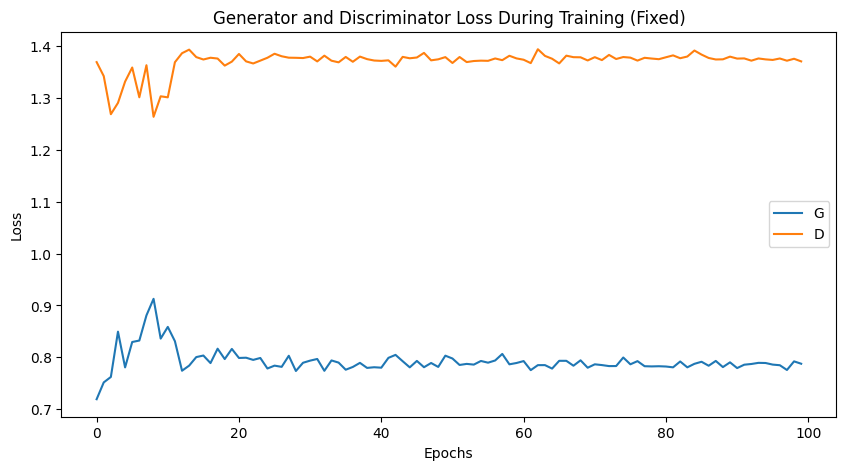

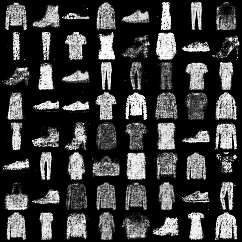

In [13]:
# =============================================================================
# ## 8. Visualisasi Hasil
# =============================================================================
plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training (Fixed)")
plt.plot(g_losses, label="G")
plt.plot(d_losses, label="D")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

from IPython.display import Image
Image(f'generated_images/epoch_{epochs}.png')